# Proyecto 03 - Series de Tiempo

## Dataset: Flujo Vehicular por Unidades de Peaje AUSA

**Recuerda descargar el dataset de [aquí](https://data.buenosaires.gob.ar/dataset/flujo-vehicular-por-unidades-peaje-ausa). Deberás descargar -  al menos para comenzar - los años 2017, 2018 y 2019.**

En este notebook te dejamos unas celdas para que puedas comenzar a trabajar con este dataset para los años 2017, 2018 y 2019. Si deseas utilizar otros años, ten en cuenta que deberás hacer el preprocesamiento correspondiente, ya que la estructura de los datos puede variar.

**Importante:** Para el proyecto, debes comenzar con los datos de la autopista Illia, pago en Efectivo.

### Exploración de datos

Dedícale un buen tiempo a hacer un Análisis Exploratorio de Datos. Elige preguntas que creas que puedas responder con este dataset. Por ejemplo, ¿Cuáles son los días y horarios de mayor tráfico? También, estudia autocorrelaciones, resampleos, etc.

#### Componentes de la serie

1. Calcula las componentes estacionales y tendencia de la serie. Interpreta los resultados, si es necesario con información auxiliar (por fuera del dataset) o elementos del dataset que no estés utilizando (por ejemplo, si la tendencia es negativa, ¿puede ser porque se migre a otras formas de pago?).
1. ¿La serie posee valores atípicos? Si es así, interpreta, si es necesario con información auxiliar. **Pista**: primer semestre 2019.

### Predicción a Futuro

Debes implementar un modelo que prediga el tráfico en la autopista Illia para el último trimestre del 2019. 

1. Haz todas las transformaciones de datos que consideres necesarias. Justifica.
1. Evalúa de forma apropiada tus resultados. Justifica la métrica elegida.
1. Elige un modelo benchmark y compara tus resultados con este modelo.
1. Optimiza los hiperparámetros de tu modelo. 
1. Intenta responder la pregunta: ¿Qué información está usando el modelo para predecir?
1. Utiliza el modelo creado para predecir el tráfico en el año 2020. ¿Cómo funciona?
1. Si lo deseas, puedes agregar información de años anteriores a 2017. ¿Mejoran los resultados?

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
import datetime as dt
import statsmodels.api as sm 

# librerías de visualizaciones
import seaborn as sns
import matplotlib.pyplot as plt 


# graficos incrustados
%matplotlib inline

# pandas solo 4 decimales
pd.set_option('precision', 4)

## Datos

In [3]:
data_2019 = pd.read_csv('flujo-vehicular-2019.csv', sep =',')
data_2018 = pd.read_csv('flujo-vehicular-2018.csv', sep =',')
data_2017 = pd.read_csv('flujo-vehicular-2017.csv', sep =',')

In [4]:
data_2017.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1372645 entries, 0 to 1372644
Data columns (total 10 columns):
 #   Column          Non-Null Count    Dtype 
---  ------          --------------    ----- 
 0   periodo         1372645 non-null  int64 
 1   fecha           1372645 non-null  object
 2   hora_inicio     1372645 non-null  int64 
 3   hora_fin        1372645 non-null  int64 
 4   dia             1372645 non-null  object
 5   estacion        1372645 non-null  object
 6   sentido         1372645 non-null  object
 7   tipo_vehiculo   1372645 non-null  object
 8   forma_pago      1372645 non-null  object
 9   cantidad_pasos  1372645 non-null  int64 
dtypes: int64(4), object(6)
memory usage: 104.7+ MB


In [5]:
data_2018.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1375908 entries, 0 to 1375907
Data columns (total 10 columns):
 #   Column          Non-Null Count    Dtype 
---  ------          --------------    ----- 
 0   periodo         1375908 non-null  int64 
 1   fecha           1375908 non-null  object
 2   hora_inicio     1375908 non-null  int64 
 3   hora_fin        1375908 non-null  int64 
 4   dia             1375908 non-null  object
 5   estacion        1375908 non-null  object
 6   sentido         1375908 non-null  object
 7   tipo_vehiculo   1375908 non-null  object
 8   forma_pago      1375908 non-null  object
 9   cantidad_pasos  1375908 non-null  int64 
dtypes: int64(4), object(6)
memory usage: 105.0+ MB


In [6]:
data_2019.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 812153 entries, 0 to 812152
Data columns (total 10 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   periodo         812153 non-null  int64 
 1   fecha           812153 non-null  object
 2   hora_inicio     812153 non-null  int64 
 3   hora_fin        812153 non-null  int64 
 4   dia             812153 non-null  object
 5   estacion        812153 non-null  object
 6   sentido         812153 non-null  object
 7   tipo_vehiculo   812153 non-null  object
 8   forma_pago      812153 non-null  object
 9   cantidad_pasos  812153 non-null  int64 
dtypes: int64(4), object(6)
memory usage: 62.0+ MB


In [7]:
data_2019.head()

,periodo,fecha,hora_inicio,hora_fin,dia,estacion,sentido,tipo_vehiculo,forma_pago,cantidad_pasos
0,2019,2019-01-01,0,1,Martes,Alberti,Centro,Liviano,NO COBRADO,22
1,2019,2019-01-01,0,1,Martes,Alberti,Centro,Liviano,TELEPASE,6
2,2019,2019-01-01,0,1,Martes,Alberti,Provincia,Liviano,NO COBRADO,53
3,2019,2019-01-01,0,1,Martes,Alberti,Provincia,Liviano,TELEPASE,18
4,2019,2019-01-01,0,1,Martes,Avellaneda,Centro,Liviano,EFECTIVO,16


In [8]:
#Unimos los 3 datasets, podemos hacerlo asi directamente ya que tienen las mismas columnas
dataset = pd.concat([data_2019, data_2018, data_2017])

#Nos quedamos solamente con la estación Illia y la forma de pago Efectivo
mask = np.logical_and(dataset.estacion=='Illia', dataset.forma_pago == 'EFECTIVO')
dataset = dataset[mask]

dataset.head()

,periodo,fecha,hora_inicio,hora_fin,dia,estacion,sentido,tipo_vehiculo,forma_pago,cantidad_pasos
80,2019,2019-01-01,1,2,Martes,Illia,Centro,Liviano,EFECTIVO,537
86,2019,2019-01-01,1,2,Martes,Illia,Centro,Pesado,EFECTIVO,1
88,2019,2019-01-01,1,2,Martes,Illia,Provincia,Liviano,EFECTIVO,443
94,2019,2019-01-01,1,2,Martes,Illia,Provincia,Pesado,EFECTIVO,1
149,2019,2019-01-01,2,3,Martes,Illia,Centro,Liviano,EFECTIVO,769


In [9]:
dataset.cantidad_pasos.describe()

count    238869.0000
mean        200.3842
std         403.2469
min           1.0000
25%           2.0000
50%          11.0000
75%         104.0000
max        2416.0000
Name: cantidad_pasos, dtype: float64

### Valores nulos

In [10]:
dataset.isna().sum()

periodo           0
fecha             0
hora_inicio       0
hora_fin          0
dia               0
estacion          0
sentido           0
tipo_vehiculo     0
forma_pago        0
cantidad_pasos    0
dtype: int64

no se observan valores nulos

#### Sentido con mayor flujo de vehículos

<AxesSubplot:xlabel='sentido', ylabel='count'>

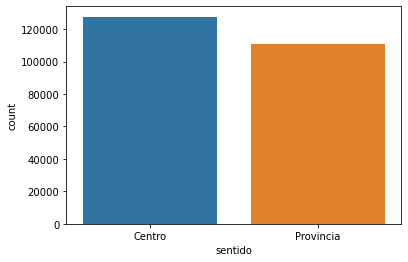

In [10]:
sns.countplot(data = dataset, x = "sentido")

#### Tipo de vehículo más frecuente

<AxesSubplot:xlabel='tipo_vehiculo', ylabel='count'>

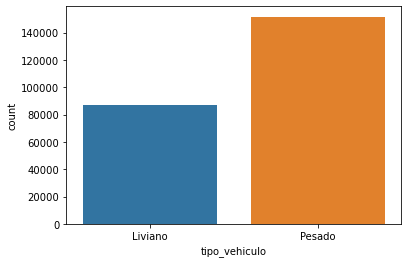

In [11]:
sns.countplot(data = dataset, x = "tipo_vehiculo")

In [13]:
##Quitamos las columnas que no vamos a utilizar
dataset.drop(columns = ['periodo','hora_inicio','forma_pago', 'estacion'], inplace = True)

In [14]:
dataset.head()

,dia,sentido,tipo_vehiculo,cantidad_pasos,fecha2
80,Martes,Centro,Liviano,537,2019-01-01 02:00:00
86,Martes,Centro,Pesado,1,2019-01-01 02:00:00
88,Martes,Provincia,Liviano,443,2019-01-01 02:00:00
94,Martes,Provincia,Pesado,1,2019-01-01 02:00:00
149,Martes,Centro,Liviano,769,2019-01-01 03:00:00


In [12]:
#Pasamos la columna fecha a formato datetime, y le unimos la hora_fin como hora
dataset['fecha2'] = pd.to_datetime(dataset.fecha) + pd.to_timedelta(dataset.hora_fin, unit = 'h')

#Quitamos las columnas fecha y hora_fin ya que las incluimos en el campo fecha2
dataset.drop(columns=['fecha','hora_fin'], inplace = True)

dataset.head()

,periodo,hora_inicio,dia,estacion,sentido,tipo_vehiculo,forma_pago,cantidad_pasos,fecha2
80,2019,1,Martes,Illia,Centro,Liviano,EFECTIVO,537,2019-01-01 02:00:00
86,2019,1,Martes,Illia,Centro,Pesado,EFECTIVO,1,2019-01-01 02:00:00
88,2019,1,Martes,Illia,Provincia,Liviano,EFECTIVO,443,2019-01-01 02:00:00
94,2019,1,Martes,Illia,Provincia,Pesado,EFECTIVO,1,2019-01-01 02:00:00
149,2019,2,Martes,Illia,Centro,Liviano,EFECTIVO,769,2019-01-01 03:00:00


In [15]:
#Corregimos el nombre de fecha2 a fecha
dataset.rename(columns = {'fecha2':'fecha'}, inplace = True) 
dataset.head()

,dia,sentido,tipo_vehiculo,cantidad_pasos,fecha
80,Martes,Centro,Liviano,537,2019-01-01 02:00:00
86,Martes,Centro,Pesado,1,2019-01-01 02:00:00
88,Martes,Provincia,Liviano,443,2019-01-01 02:00:00
94,Martes,Provincia,Pesado,1,2019-01-01 02:00:00
149,Martes,Centro,Liviano,769,2019-01-01 03:00:00


In [16]:
#Reordenamos el dataset por fecha
dataset.sort_values('fecha', inplace = True)
dataset.reset_index(drop=True, inplace = True)
dataset

,dia,sentido,tipo_vehiculo,cantidad_pasos,fecha
0,Domingo,Provincia,Pesado,1,2017-01-01 00:00:00
1,Domingo,Provincia,Liviano,9,2017-01-01 00:00:00
2,Domingo,Provincia,Liviano,644,2017-01-01 00:00:00
3,Domingo,Provincia,Pesado,6,2017-01-01 00:00:00
4,Domingo,Provincia,Pesado,1,2017-01-01 00:00:00
...,...,...,...,...,...
238864,Martes,Provincia,Liviano,556,2019-12-31 22:00:00
238865,Martes,Provincia,Pesado,1,2019-12-31 22:00:00
238866,Martes,Centro,Liviano,580,2019-12-31 22:00:00
238867,Martes,Centro,Liviano,214,2019-12-31 23:00:00


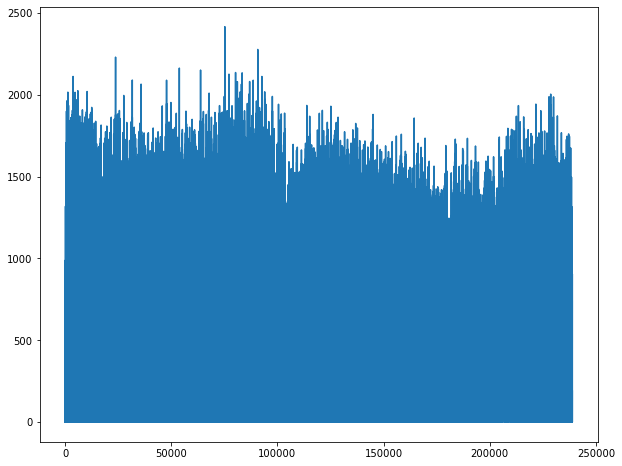

In [17]:
plot = dataset['cantidad_pasos'].plot(figsize=(10, 8))

#### ¿Cuál fué el día de la semana con más pases?

In [18]:
masc_h= dataset[dataset.cantidad_pasos>=(dataset.cantidad_pasos.mean()+ dataset.cantidad_pasos.std())]
masc_h

,dia,sentido,tipo_vehiculo,cantidad_pasos,fecha
2,Domingo,Provincia,Liviano,644,2017-01-01 00:00:00
11,Domingo,Centro,Liviano,857,2017-01-01 00:00:00
16,Domingo,Centro,Liviano,783,2017-01-01 02:00:00
19,Domingo,Provincia,Liviano,704,2017-01-01 03:00:00
22,Domingo,Centro,Liviano,988,2017-01-01 03:00:00
...,...,...,...,...,...
238850,Martes,Provincia,Liviano,643,2019-12-31 18:00:00
238854,Martes,Provincia,Liviano,640,2019-12-31 19:00:00
238858,Martes,Provincia,Liviano,773,2019-12-31 20:00:00
238861,Martes,Provincia,Liviano,905,2019-12-31 21:00:00


In [19]:
masc_h.groupby('dia').sum().sort_values('cantidad_pasos', ascending=False)

,cantidad_pasos
dia,
Viernes,6260472
Jueves,5892907
Miércoles,5674526
Martes,5442516
Lunes,5225756
Sábado,5182949
Domingo,4299132


El dia con mayor flujo vehicular son los dias viernes

#### ¿Cuál fué la hora y de que fecha con más pases?

In [20]:
masc_h.groupby('fecha').sum().sort_values('cantidad_pasos', ascending=False)

,cantidad_pasos
fecha,
2017-10-05 18:00:00,3842
2017-10-13 15:00:00,3794
2017-11-17 14:00:00,3738
2017-12-07 16:00:00,3726
2017-10-13 16:00:00,3629
...,...
2019-10-24 23:00:00,604
2018-03-10 00:00:00,604
2018-02-12 09:00:00,604


el dia con más pases fue el 05/10/2017 a las 18:00 hs

### Diario

In [21]:
#Resampleamos nuestros datos para agrupar por dia, y asi tal vez lograr una visualización mas amigable
diario = dataset.resample('D', on = 'fecha').sum()
print(diario.shape)
diario.head()

(1095, 1)


,cantidad_pasos
fecha,
2017-01-01,31183
2017-01-02,51568
2017-01-03,51093
2017-01-04,53332
2017-01-05,56486


In [22]:
diario.cantidad_pasos.describe()

count     1095.0000
mean     43712.8594
std       8192.7369
min          0.0000
25%      39061.5000
50%      43761.0000
75%      49498.0000
max      63127.0000
Name: cantidad_pasos, dtype: float64

<AxesSubplot:xlabel='cantidad_pasos'>

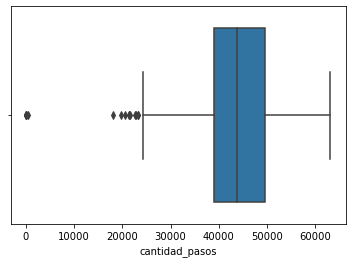

In [23]:
sns.boxplot(data = diario, x = "cantidad_pasos")

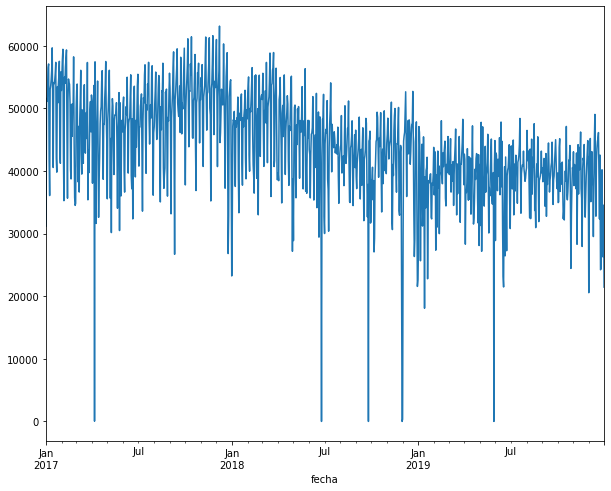

In [23]:
plot = diario['cantidad_pasos'].plot(figsize=(10, 8))

#### Valores atípicos 

In [24]:
#valores atípicos
diario_1 = diario.copy()
diario_1.describe()

,cantidad_pasos
count,1095.0000
mean,43712.8594
std,8192.7369
min,0.0000
25%,39061.5000
50%,43761.0000
75%,49498.0000
max,63127.0000


In [25]:
limite = diario.mean() + 3*diario.std()
limite

cantidad_pasos    68291.0701
dtype: float64

In [26]:
diario_1 = diario[diario.cantidad_pasos <= 10000]
diario_1

,cantidad_pasos
fecha,
2017-04-06,40
2018-06-25,0
2018-09-25,0
2018-11-30,0
2018-12-01,350
2019-05-29,0


Se observan los 6 valores atipicos por debajo de 10000. Se toma la decision de reemplazar eso valores atípicos mediante la interpolacion.

La interpolación es el proceso de encontrar un valor entre dos puntos en una línea o una curva. Para ayudarnos a recordar lo que significa, debemos pensar en la primera parte de la palabra, 'inter', como si significara 'ingresar', lo que nos recuerda que debemos mirar 'dentro' de los datos que teníamos originalmente. Esta herramienta, la interpolación, no solo es útil en estadísticas, sino que también es útil en ciencia, negocios o cuando existe la necesidad de predecir valores que se encuentran dentro de dos puntos de datos existentes.

In [27]:
diario.cantidad_pasos[diario.cantidad_pasos <=10000] = np.nan

In [28]:
print(diario.isna().sum())
diario = diario.interpolate(method='nearest', k = 4)
print(diario.isna().sum())

cantidad_pasos    6
dtype: int64
cantidad_pasos    0
dtype: int64


In [29]:
diario.describe()

,cantidad_pasos
count,1095.0000
mean,43909.1114
std,7586.0171
min,18076.0000
25%,39085.5000
50%,43766.0000
75%,49514.5000
max,63127.0000


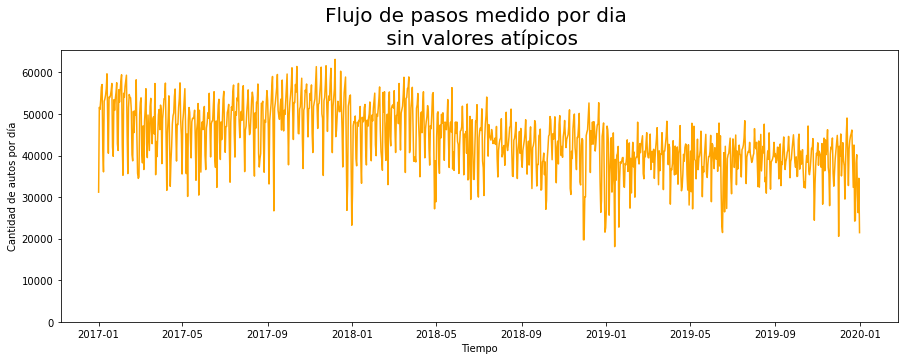

In [30]:
plt.figure(figsize = (15,5))
plt.plot(diario.index, diario.cantidad_pasos, color = 'orange')
plt.title("Flujo de pasos medido por dia \n sin valores atípicos", color= 'black', fontsize= 20)
plt.xlabel('Tiempo')
plt.ylabel('Cantidad de autos por día')
plt.ylim(ymin=0)
plt.show()

In [31]:
# Aplicando el filtro Hodrick-Prescott para separar en tendencia y 
# componente ciclico.
ciclo, tend = sm.tsa.filters.hpfilter(diario['cantidad_pasos'])
diario['tend'] = tend

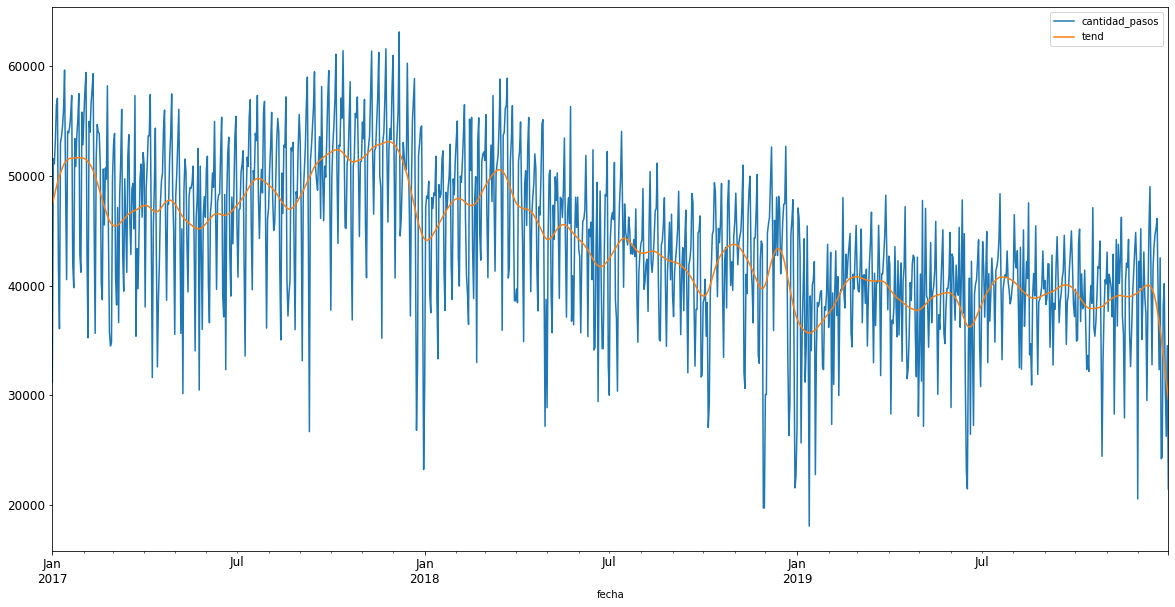

In [32]:
diario[['cantidad_pasos', 'tend']].plot(figsize=(20,10),fontsize=12);
legend = plt.legend()
legend.prop.set_size(14);

En este grafico se observa la tendencia diaria de la serie, donde claramente se observan picos donde hay mayor flujo vehicular que luego caen y disminuye. No hay una clara tendencia.

<ipython-input-33-57c3082f78a5>:2: FutureWarning: the 'freq'' keyword is deprecated, use 'period' instead
  descomposicion_diaria = sm.tsa.seasonal_decompose(diario['cantidad_pasos'],


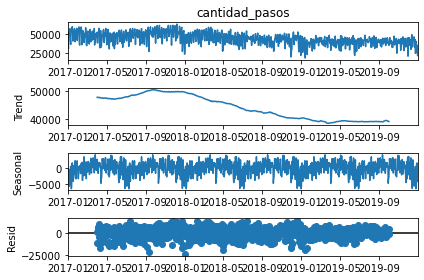

In [33]:
# descomposición de serie de tiempo diaria
descomposicion_diaria = sm.tsa.seasonal_decompose(diario['cantidad_pasos'],
                                                 model='additive', freq=180) 
fig = descomposicion_diaria.plot()

En este grafico de descomposición, se puede observar los 3 componentes de la serie: Tendencia, estacionalidad y Residuo (Ruido blanco).
En este caso se observa una tendencia a disminuir a partir del mes de septiembre del 2018

In [35]:
# desplazar la serie 1 dia para atras con pct_change()
diario['cantidad_pasos'].pct_change()[:5]

fecha
2017-01-01       NaN
2017-01-02    0.6537
2017-01-03   -0.0092
2017-01-04    0.0438
2017-01-05    0.0591
Freq: D, Name: cantidad_pasos, dtype: float64

In [36]:
# calculando rendimiento acumulado diario
rendimiento_diario = (1 + diario['cantidad_pasos'].pct_change()).cumprod()
diario['rend_diario'] = rendimiento_diario
diario['rend_diario'][:5]

fecha
2017-01-01       NaN
2017-01-02    1.6537
2017-01-03    1.6385
2017-01-04    1.7103
2017-01-05    1.8114
Freq: D, Name: rend_diario, dtype: float64

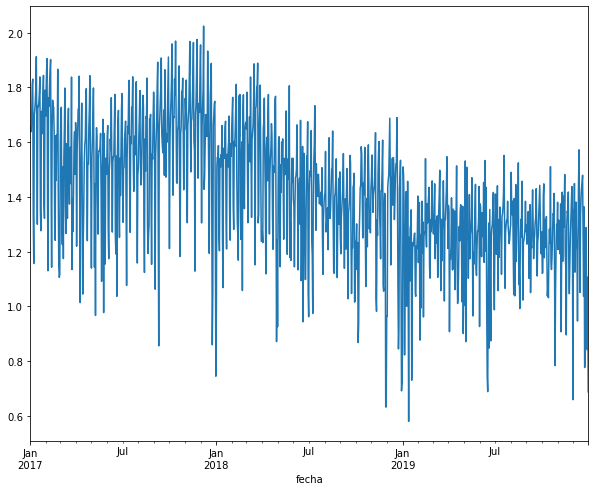

In [37]:
# graficando rendimiento diario
plot = diario['rend_diario'].plot(figsize=(10, 8))

In [38]:
# calculando el porcentaje de variación del día.
variacion_diaria = diario['cantidad_pasos'] / diario['cantidad_pasos'].shift(1) - 1
diario['var_diaria'] = variacion_diaria
diario['var_diaria'][:5]

fecha
2017-01-01       NaN
2017-01-02    0.6537
2017-01-03   -0.0092
2017-01-04    0.0438
2017-01-05    0.0591
Freq: D, Name: var_diaria, dtype: float64

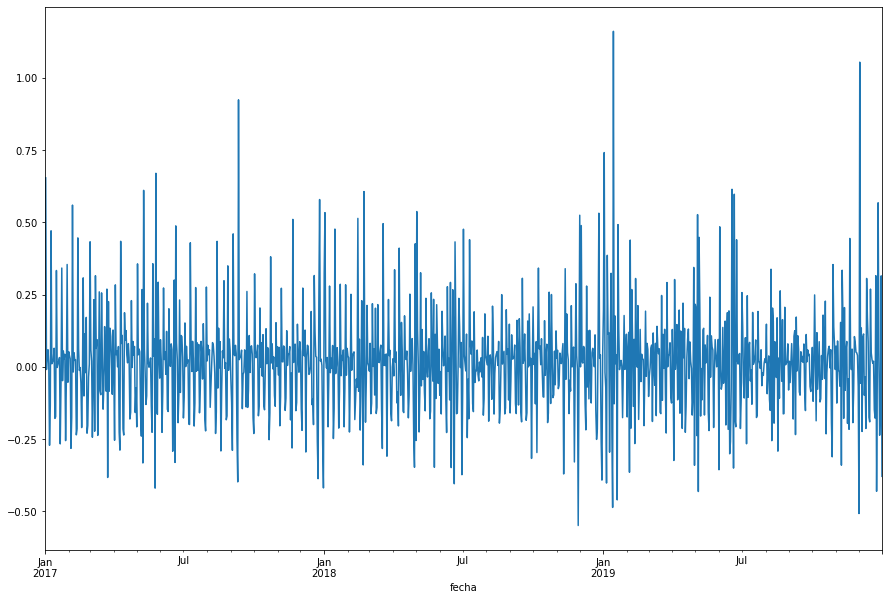

In [39]:
# graficando variacion diaria
plot = diario['var_diaria'].plot(figsize=(15, 10))

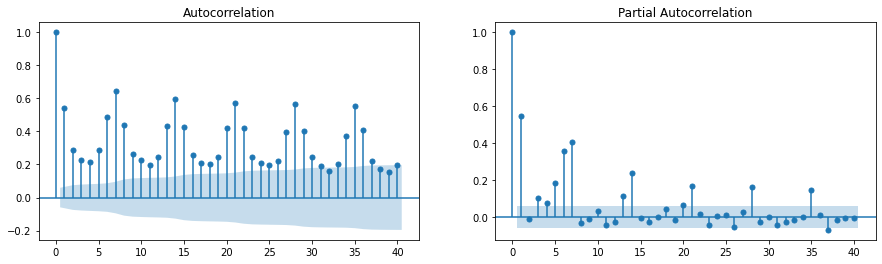

In [40]:
fig, axes = plt.subplots(1, 2, figsize=(15,4))

fig = sm.graphics.tsa.plot_acf(diario['cantidad_pasos'], lags=40, ax=axes[0])
fig = sm.graphics.tsa.plot_pacf(diario['cantidad_pasos'], lags=40, ax=axes[1])

### Semanal

In [41]:
#Resampleamos nuestros datos para agrupar por semana
semanal = dataset.resample('W', on = 'fecha').sum()
print(semanal.shape)
semanal.head()

(158, 1)


,cantidad_pasos
fecha,
2017-01-01,31183
2017-01-08,347212
2017-01-15,366413
2017-01-22,357215
2017-01-29,354581


In [42]:
semanal.cantidad_pasos.describe()

count       158.0000
mean     302946.7152
std       47342.8544
min       31183.0000
25%      276345.2500
50%      307094.0000
75%      334921.5000
max      377832.0000
Name: cantidad_pasos, dtype: float64

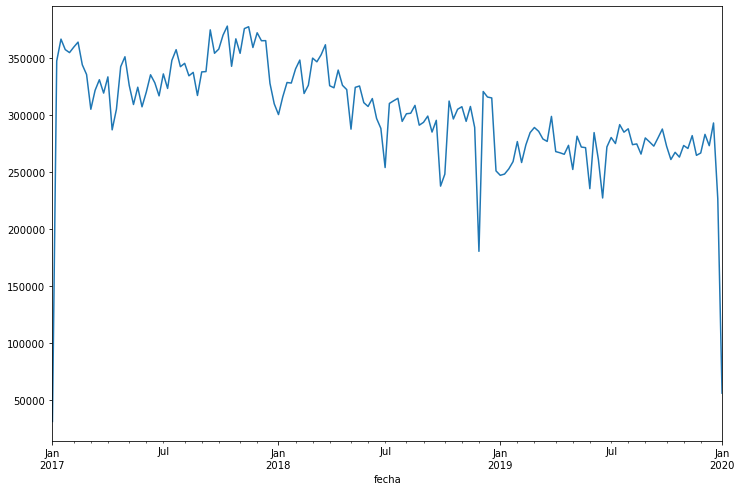

In [43]:
plot = semanal['cantidad_pasos'].plot(figsize=(12, 8))

<AxesSubplot:xlabel='cantidad_pasos'>

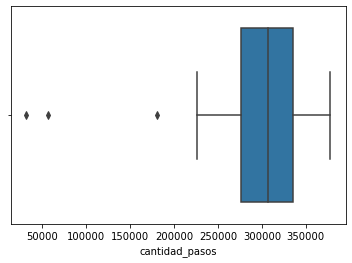

In [44]:
sns.boxplot(data = semanal, x = "cantidad_pasos")

In [45]:
# Aplicando el filtro Hodrick-Prescott para separar en tendencia y 
# componente ciclico.
ciclo, tend = sm.tsa.filters.hpfilter(semanal['cantidad_pasos'])
semanal['tend'] = tend

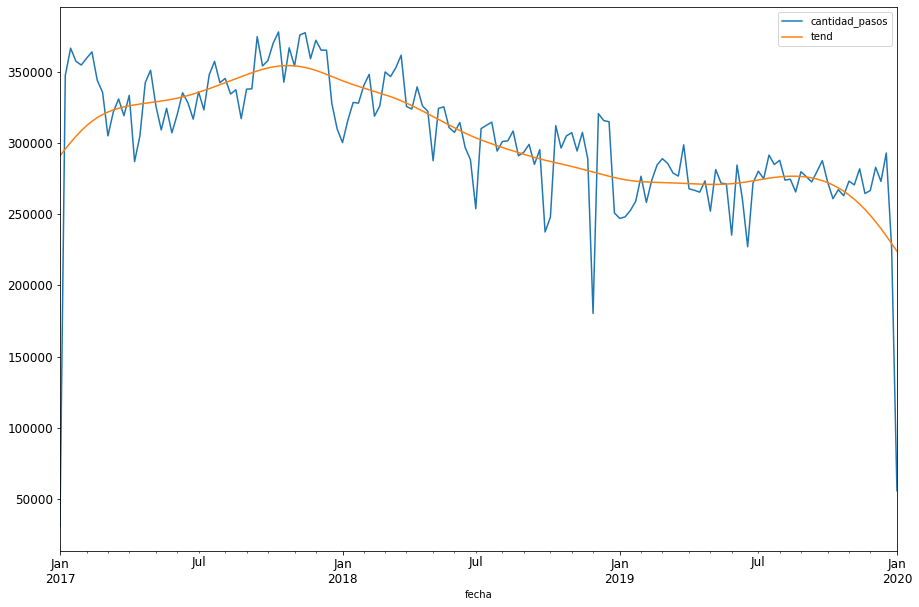

In [46]:
semanal[['cantidad_pasos', 'tend']].plot(figsize=(15, 10), fontsize=12);
legend = plt.legend()
legend.prop.set_size(14);

<ipython-input-47-32853e2dc2f6>:2: FutureWarning: the 'freq'' keyword is deprecated, use 'period' instead
  descomposicion_semanal = sm.tsa.seasonal_decompose(semanal['cantidad_pasos'],


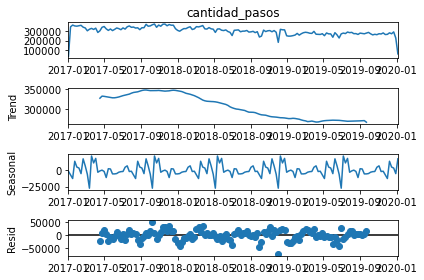

In [47]:
 #Ejemplo de descomposición de serie de tiempo
descomposicion_semanal = sm.tsa.seasonal_decompose(semanal['cantidad_pasos'],
                                                  model='additive', freq=30)  
fig = descomposicion_semanal.plot()

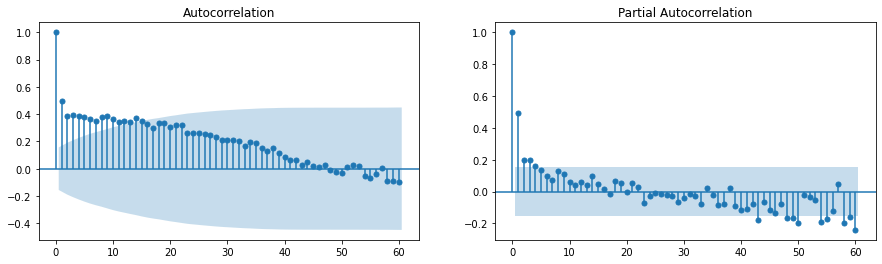

In [48]:
fig, axes = plt.subplots(1, 2, figsize=(15,4))

fig = sm.graphics.tsa.plot_acf(semanal['cantidad_pasos'], lags=60, ax=axes[0])
fig = sm.graphics.tsa.plot_pacf(semanal['cantidad_pasos'], lags=60, ax=axes[1])

Media movil

Con el método rolling() se calcula la media deslizante de 7 días de datos diarios. Usando el argumento center=True, se etiqueta cada ventana en su punto medio. Con la media movil podemos ver el promedio, en este caso cada siete dias.

In [49]:
semana_7d = diario['cantidad_pasos'].rolling(7, center=True).mean()
semana_7d.head(5)

fecha
2017-01-01           NaN
2017-01-02           NaN
2017-01-03           NaN
2017-01-04    48904.2857
2017-01-05    49601.7143
Freq: D, Name: cantidad_pasos, dtype: float64

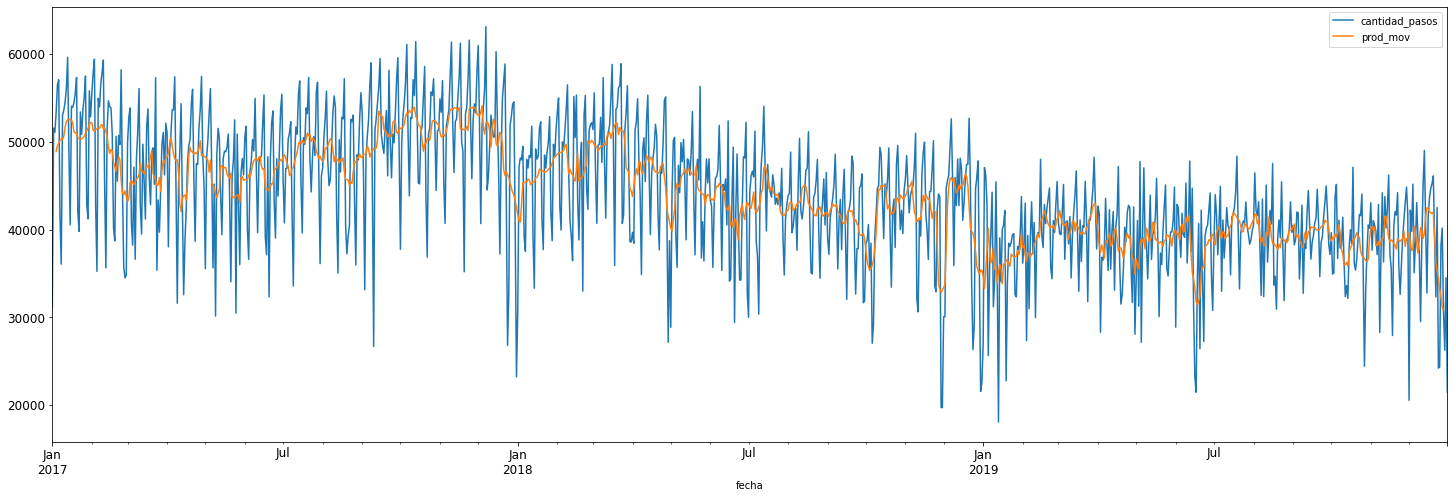

In [50]:
#graficamos el promedio movil (7dias)
diario['prod_mov'] = semana_7d
plot = diario[['cantidad_pasos', 'prod_mov']].plot(figsize=(25, 8), fontsize=12)

Aqui se observa la media movil cada 7 dias, es decir, el promedio de vehiculos que pasan cada 7 dias por el peaje. Observamos una tendencia 

###  Machine Learning - Predicción a futuro

#### Modelo benchmark

In [51]:
from sklearn.metrics import mean_squared_error

In [52]:
semanal_m =diario.resample('W').mean()
print(semanal_m.shape)
semanal_m

(158, 5)


,cantidad_pasos,tend,rend_diario,var_diaria,prod_mov
fecha,,,,,
2017-01-01,31183.0000,47372.1607,NaN,NaN,NaN
2017-01-08,49601.7143,48955.0627,1.5907,0.0505,49765.4000
2017-01-15,52344.7143,50917.1887,1.6786,0.0342,51790.2449
2017-01-22,51030.7143,51584.6327,1.6365,0.0104,51224.9388
2017-01-29,50654.4286,51651.2956,1.6244,0.0181,50801.1429
...,...,...,...,...,...
2019-12-08,40413.0000,39694.6734,1.2960,0.1466,38520.5306
2019-12-15,38994.2857,39948.4318,1.2505,-0.0070,40209.5714
2019-12-22,41840.1429,38255.2226,1.3418,0.0070,40825.7959


In [53]:
semanal_mean = semanal_m['cantidad_pasos']

In [54]:
semanal_mean

fecha
2017-01-01    31183.0000
2017-01-08    49601.7143
2017-01-15    52344.7143
2017-01-22    51030.7143
2017-01-29    50654.4286
                 ...    
2019-12-08    40413.0000
2019-12-15    38994.2857
2019-12-22    41840.1429
2019-12-29    32341.4286
2020-01-05    27985.0000
Freq: W-SUN, Name: cantidad_pasos, Length: 158, dtype: float64

In [55]:
# 3ª trimestre 2019
fecha_i='2019-07-01'
fecha_f='2019-09-30'
X= semanal_mean [(semanal_mean.index >=fecha_i)&(semanal_mean.index <=fecha_f)]

# 4º trimestre 2019 = Ultimo trimestre  2019
fecha_i='2019-10-01'
fecha_f='2019-12-31'
y=semanal_mean [(semanal_mean.index >=fecha_i)&(semanal_mean.index <=fecha_f)]

y_t=X.rolling(window=1, center=True).mean()

In [56]:
b_rmse=np.sqrt(mean_squared_error(y, y_t))

---------------------------------
RMSE en Benchmark: 2999.8287232635216
---------------------------------


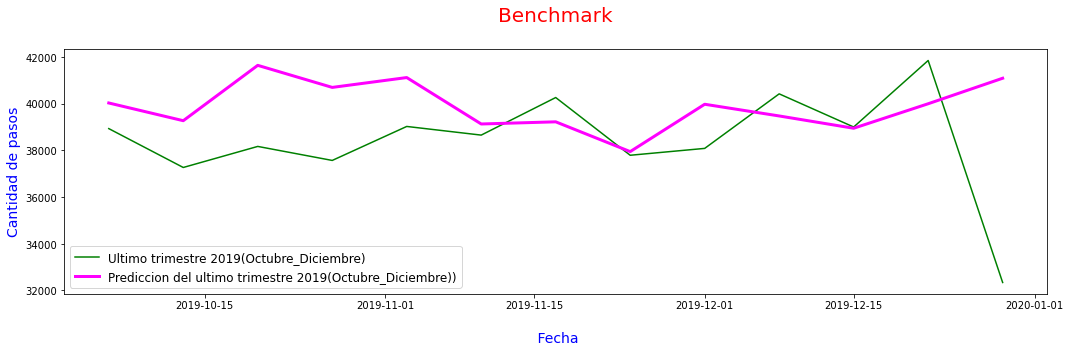

In [57]:
print('---------------------------------')
print(f'RMSE en Benchmark: {b_rmse}')
print('---------------------------------')

plt.figure(figsize=(15,5))
plt.plot(y.index, y,color='green', label='Ultimo trimestre 2019(Octubre_Diciembre)')
plt.plot(y.index, y_t, lw=3, color='magenta',label='Prediccion del ultimo trimestre 2019(Octubre_Diciembre))')
plt.title ('Benchmark\n', color='red', fontsize=20)
plt.xlabel('\n Fecha', color='blue',fontsize=14)
plt.ylabel('Cantidad de pasos', color='blue',fontsize=14)

plt.legend(fontsize=12)
plt.tight_layout()
plt.show()

#### Random forest

In [81]:
#preparando datos para random forest
senial = semanal_mean
senial

fecha
2017-01-01    31183.0000
2017-01-08    49601.7143
2017-01-15    52344.7143
2017-01-22    51030.7143
2017-01-29    50654.4286
                 ...    
2019-12-08    40413.0000
2019-12-15    38994.2857
2019-12-22    41840.1429
2019-12-29    32341.4286
2020-01-05    27985.0000
Freq: W-SUN, Name: cantidad_pasos, Length: 158, dtype: float64

In [82]:
look_back = 12 # usamos 12 semanas de datos para predecir el valor siguiente

In [83]:
N = senial.shape[0]
X = np.zeros((N - look_back - 1,look_back))
y = np.zeros(N - look_back - 1)
print(X.shape, y.shape)

(145, 12) (145,)


In [84]:
for i in range(X.shape[0]):
    X[i,:] = senial.iloc[i:i+look_back]
    y[i] = senial.iloc[i+look_back]

In [85]:
N_train = 145 - look_back # cantidad de instancias que vamos a usar para entrenar. look_back = 12 semanas 
N_test = 12  #cantidad de puntos que vamos a usar para evaluar
N_total = N_train + N_test

length_total = N_train + N_test + look_back

X_train = X[:N_train,:]
y_train = y[:N_train]
print(X_train.shape, y_train.shape)

X_test = X[N_train:N_train+N_test,:]
y_test = y[N_train:N_train+N_test]
print(X_test.shape, y_test.shape)

(133, 12) (133,)
(12, 12) (12,)


In [86]:
y_test = y[N_train:N_train+N_test]
print(y_test)

[37262.85714286 38163.85714286 37564.28571429 39018.42857143
 38648.         40255.71428571 37785.71428571 38079.28571429
 40413.         38994.28571429 41840.14285714 32341.42857143]


In [87]:
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor( random_state=42, n_jobs = -1)

In [88]:
rf.fit(X_train,y_train)

RandomForestRegressor(n_jobs=-1, random_state=42)

In [89]:
y_train_pred = rf.predict(X_train)
y_test_pred = rf.predict(X_test)

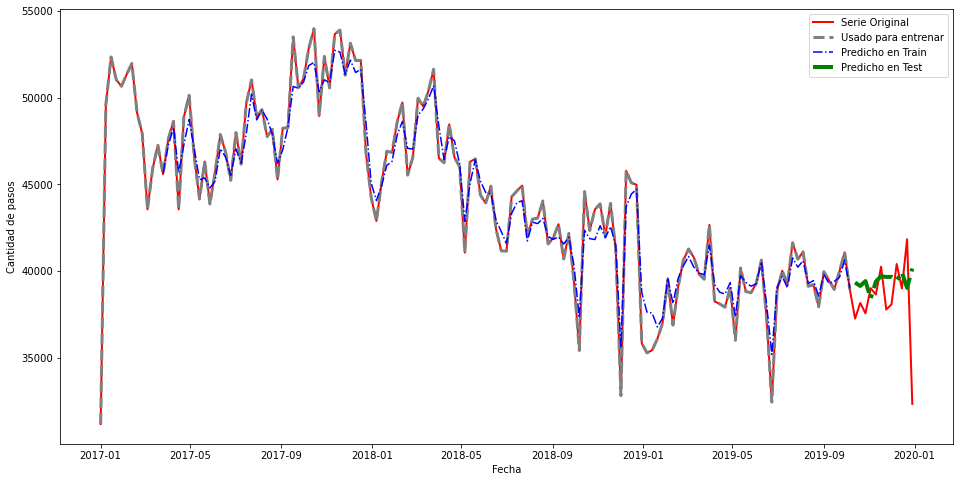

RMSE RFR en Train: 1024.8765006305243
RMSE RFR en Test: 2686.596430594925


In [90]:
plt.figure(figsize=(16,8))
plt.plot(senial.index[:length_total], senial[:length_total],lw = 2, color='red', label = 'Serie Original')
plt.plot(senial.index[:N_train + look_back], senial[:N_train + look_back],'--', lw = 3,color='grey',label = 'Usado para entrenar')
plt.plot(senial.index[look_back: look_back + N_train], y_train_pred,'-.',color='blue',label = 'Predicho en Train')
plt.plot(senial.index[N_train+look_back: length_total], y_test_pred,'-.',color='green', lw = 4, label = 'Predicho en Test')
plt.legend()
plt.xlabel('Fecha')
plt.ylabel('Cantidad de pasos')
plt.show()
rmse =np.sqrt( mean_squared_error(y_train, y_train_pred))
print('RMSE RFR en Train:',rmse)

rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
print('RMSE RFR en Test:',rmse)

In [91]:
from sklearn.model_selection import  GridSearchCV, TimeSeriesSplit
tss= TimeSeriesSplit(n_splits=2)

In [92]:
param_grid = {'n_estimators':[ 20, 50,100,200],
              'max_depth': [i for i in range(2,20)],
              'max_features': ['auto', 'sqrt', 'log2'], 
              'min_samples_split': [2, 5, 10],
              'min_samples_leaf': [1, 2, 4, 6]} 
rf_reg=RandomForestRegressor(random_state=42)
rf_gs =GridSearchCV(rf_reg, param_grid, scoring='neg_root_mean_squared_error', cv=tss,verbose=5,n_jobs=-1)

In [93]:
rf_gs.fit(X_train,y_train)

Fitting 2 folds for each of 2592 candidates, totalling 5184 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done  58 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 384 tasks      | elapsed:    5.4s
[Parallel(n_jobs=-1)]: Done 888 tasks      | elapsed:   11.0s
[Parallel(n_jobs=-1)]: Done 1536 tasks      | elapsed:   19.0s
[Parallel(n_jobs=-1)]: Done 2328 tasks      | elapsed:   28.6s
[Parallel(n_jobs=-1)]: Done 3264 tasks      | elapsed:   41.1s
[Parallel(n_jobs=-1)]: Done 4344 tasks      | elapsed:   55.1s
[Parallel(n_jobs=-1)]: Done 5184 out of 5184 | elapsed:  1.1min finished


GridSearchCV(cv=TimeSeriesSplit(max_train_size=None, n_splits=2),
             estimator=RandomForestRegressor(random_state=42), n_jobs=-1,
             param_grid={'max_depth': [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,
                                       14, 15, 16, 17, 18, 19],
                         'max_features': ['auto', 'sqrt', 'log2'],
                         'min_samples_leaf': [1, 2, 4, 6],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [20, 50, 100, 200]},
             scoring='neg_root_mean_squared_error', verbose=5)

In [94]:
rf_gs.best_params_

{'max_depth': 5,
 'max_features': 'auto',
 'min_samples_leaf': 2,
 'min_samples_split': 5,
 'n_estimators': 100}

#### Random forest con mejores hiperparámetros

In [95]:
rf_h = RandomForestRegressor(max_depth= 5,
                             max_features= 'auto',
                             n_estimators= 100, 
                             random_state=42,
                             min_samples_leaf=2,
                             min_samples_split= 5,
                             n_jobs = -1)

In [96]:
rf_h.fit(X_train,y_train)

RandomForestRegressor(max_depth=5, min_samples_leaf=2, min_samples_split=5,
                      n_jobs=-1, random_state=42)

In [97]:
y_train_pred = rf_h.predict(X_train)
y_test_pred = rf_h.predict(X_test)

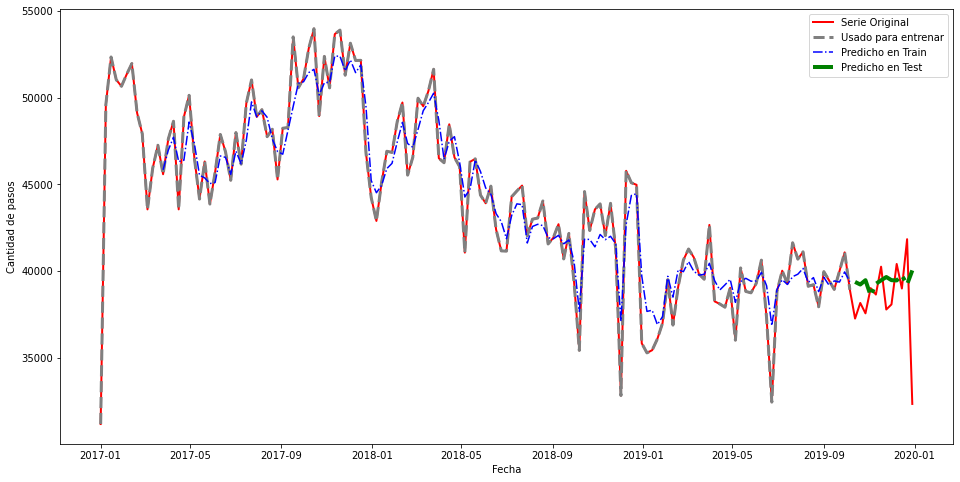

RMSE RFR en Train: 1408.1590895924824
RMSE RFR en Test: 2637.5020682810773


In [98]:
plt.figure(figsize=(16,8))
plt.plot(senial.index[:length_total], senial[:length_total],lw = 2, color='red', label = 'Serie Original')
plt.plot(senial.index[:N_train + look_back], senial[:N_train + look_back],'--', lw = 3,color='grey',label = 'Usado para entrenar')
plt.plot(senial.index[look_back: look_back + N_train], y_train_pred,'-.',color='blue',label = 'Predicho en Train')
plt.plot(senial.index[N_train+look_back: length_total], y_test_pred,'-.',color='green', lw = 4, label = 'Predicho en Test')
plt.legend()
plt.xlabel('Fecha')
plt.ylabel('Cantidad de pasos')
plt.show()
rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
print('RMSE RFR en Train:',rmse)

rmse =np.sqrt( mean_squared_error(y_test, y_test_pred))
print('RMSE RFR en Test:',rmse)

#### Comparación de resultados

RMSE en Benchmark: 2999.8287232635216
Random forest
RMSE RFR en Train: 1024.8765006305239
RMSE RFR en Test: 2686.596430594925
Optimizacion de hiperparámetros
RMSE RFR en Train: 1408.1590895924826
RMSE RFR en Test: 2637.5020682810764
Al observar los resultados no se observa una notable disminucion del error en test para el modelo de bosque aleatoria con optimización de hiperparámetros. Con respecto al modelo benchmark, disminuye el error pero tampoco con una mejoria notable. 
Al observar las predicciones notamos la naturaleza de una serie de tiempo, que contiene un elemento estacionario, el cual no es tomado en cuenta al momento de hacer las predicciones. 

### Modelos pronósticos para series de tiempo

Queremos pronosticar la cantidad de autos por hora del día. Para esto, utilizamos la variable dependiente o target (la cantidad de pasos) en un tiempo anterior como variable independiente o feature.
El tipo de modelos que sigue esta filosofía se llaman AutoRegresivos o AR y utilizaremos una variante más avanzada llamada SARIMA (Seasonal AutoRegressive Integrated Moving Average). Estos modelos consideran además la estacionalidad, lo que permite incorporar el patrón repetitivo de cada día.

Autoregressive Model AR

In [76]:
from statsmodels.tsa.ar_model import AutoReg
from sklearn.metrics import mean_squared_error
from math import sqrt

In [77]:
diario.cantidad_pasos

fecha
2017-01-01    31183.0
2017-01-02    51568.0
2017-01-03    51093.0
2017-01-04    53332.0
2017-01-05    56486.0
               ...   
2019-12-27    40182.0
2019-12-28    30681.0
2019-12-29    26259.0
2019-12-30    34523.0
2019-12-31    21447.0
Freq: D, Name: cantidad_pasos, Length: 1095, dtype: float64

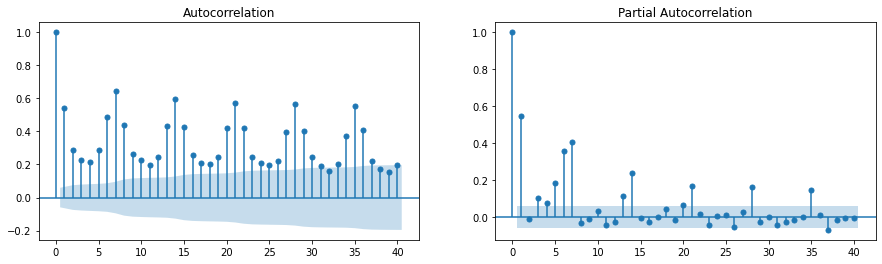

In [78]:
# Graph data
fig, axes = plt.subplots(1, 2, figsize=(15,4))

fig = sm.graphics.tsa.plot_acf(diario['cantidad_pasos'], lags=40, ax=axes[0])
fig = sm.graphics.tsa.plot_pacf(diario['cantidad_pasos'], lags=40, ax=axes[1])

Prueba ADF: 
Devuelve el valor - p - de la pruea Augmented Dickey-Fuller (ADF)

In [79]:
from statsmodels.tsa.stattools import adfuller
from matplotlib import pyplot

In [80]:
estadistica = adfuller(diario['cantidad_pasos'])
print('ADF Statistic: {}'.format(estadistica[0]))
print('p-value: {}'.format(estadistica[1]))
print('Critical Values:')
for key, value in estadistica[4].items():
    print('\t{}: {}'.format(key, value))

ADF Statistic: -1.7724769863530825
p-value: 0.3942091561421869
Critical Values:
	1%: -3.4364533503600962
	5%: -2.864234857527328
	10%: -2.568204837482531


La estadística ADF está lejos de los valores críticos y el valor p es mayor que el umbral (0.05). Por tanto, podemos concluir que la serie temporal no es estacionaria

como la estdistica ADF nos indica que la serie no es estacionaria, debemos covertirla primero en estacionaria antes de pronosticar con los modelos autoregresivos. Primero vamos a calcular la primera diferencia, es decir, llevamos la serie un periodo de retraso. 

In [81]:
diario_diff = diario.diff(periods=1)
# integrated of order 1

In [82]:
diario_diff = diario_diff[1:]
diario_diff.head()

,cantidad_pasos,tend,rend_diario,var_diaria,prod_mov
fecha,,,,,
2017-01-02,20385.0,430.5490,NaN,NaN,NaN
2017-01-03,-475.0,420.4307,-0.0152,-0.6629,NaN
2017-01-04,2239.0,402.5476,0.0718,0.0530,NaN
2017-01-05,3154.0,378.6932,0.1011,0.0153,697.4286
2017-01-06,595.0,351.8090,0.0191,-0.0486,209.7143


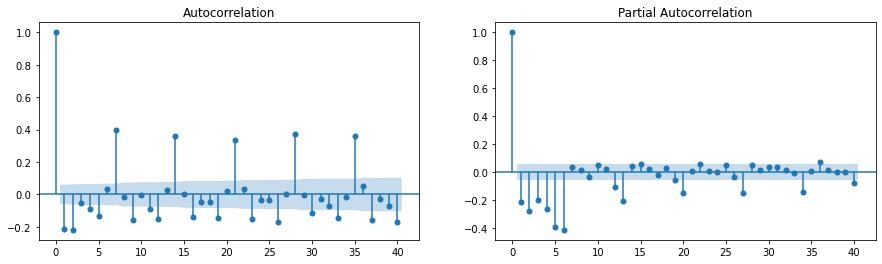

In [83]:
fig, axes = plt.subplots(1, 2, figsize=(15,4))

fig = sm.graphics.tsa.plot_acf(diario_diff['cantidad_pasos'], lags=40, ax=axes[0])
fig = sm.graphics.tsa.plot_pacf(diario_diff['cantidad_pasos'], lags=40, ax=axes[1])

In [84]:
estadistica_2 = adfuller(diario_diff['cantidad_pasos'])
print('ADF Statistic: {}'.format(estadistica_2[0]))
print('p-value: {}'.format(estadistica_2[1]))
#print('Critical Values:')
#for key, value in estadistica_2[4].items():
    #print('\t{}: {}'.format(key, value))

ADF Statistic: -12.404016901381183
p-value: 4.49447922349533e-23


<AxesSubplot:xlabel='fecha'>

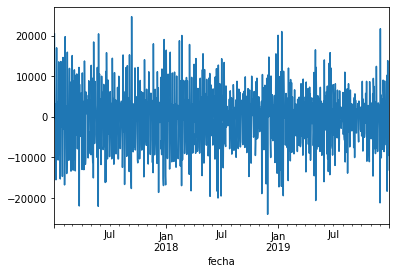

In [85]:
diario_diff.cantidad_pasos.plot()

Con una diferencia, la serie se vuelve estacionaria, el valor de la prueba de dicky fuller es menor a 0.05.
En el grafico de corrrelacion parcial, se observa que a partir de  6 lags,no se hace significativo el cambio

In [86]:
#  datos (vamos a usar los datos diarios)
series = diario.cantidad_pasos
# split dataset
X = series.values
ar_train, ar_test = X[1:len(X)-7], X[len(X)-7:]

In [87]:
# train autoregression
model = AutoReg(ar_train, lags=7)
model_fit = model.fit()
print('Coefficients: %s' % model_fit.params)

Coefficients: [ 5.02383918e+03  3.10086674e-01 -6.73709033e-02  4.44018012e-02
 -1.51521007e-02  3.06725864e-02  1.65052714e-01  4.17065240e-01]


C:\Users\Daniela-Ezequiel\miniconda3\envs\datascience\lib\site-packages\statsmodels\tsa\ar_model.py:248: FutureWarning: The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use the old names. 
  warnings.warn(


predicted=38028.493832, expected=24349.000000
predicted=44270.249366, expected=38168.000000
predicted=43337.728844, expected=40182.000000
predicted=39835.074944, expected=30681.000000
predicted=37095.316064, expected=26259.000000
predicted=37998.574039, expected=34523.000000
predicted=33155.546391, expected=21447.000000
Test RMSE: 9139.531


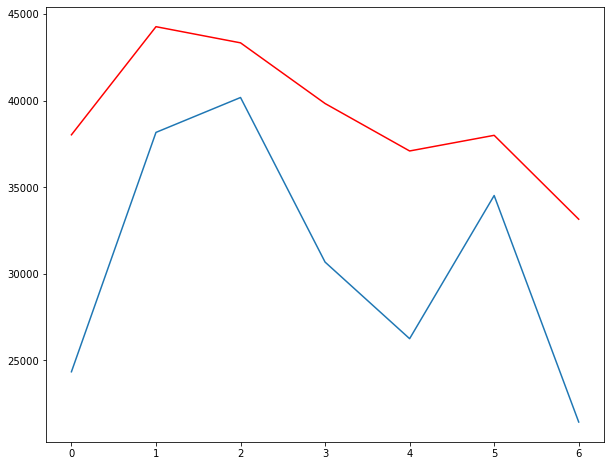

In [88]:
# predicciones a 7 días
predictions = model_fit.predict(start=len(ar_train), end=len(ar_train)+len(ar_test)-1, dynamic=False)
for i in range(len(predictions)):
	print('predicted=%f, expected=%f' % (predictions[i], ar_test[i]))
rmse = sqrt(mean_squared_error(ar_test, predictions))
print('Test RMSE: %.3f' % rmse)
plt.figure(figsize=(10,8))
pyplot.plot(ar_test)
pyplot.plot(predictions, color='red')
pyplot.show()

En el grafico se puede observar las predicciones del modelo (rojo) junto con los valores del conjunto de test (azul), con un RMSE de 9139.531

SARIMAX

In [148]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

# definir conjunto de datos
x = diario.cantidad_pasos

# instanciar modelo
sarima_model = SARIMAX(x, order=(2,1,2), seasonal_order=(2, 1, 2, 7))

# ajustar modelo
resultados = sarima_model.fit()

# mirar el AIC
resultados.aic

21736.48782654194

In [92]:
print(resultados.summary())

                                     SARIMAX Results                                     
Dep. Variable:                    cantidad_pasos   No. Observations:                 1095
Model:             SARIMAX(2, 1, 2)x(2, 1, 2, 7)   Log Likelihood              -10859.244
Date:                           Wed, 07 Jul 2021   AIC                          21736.488
Time:                                   17:39:49   BIC                          21781.408
Sample:                               01-01-2017   HQIC                         21753.492
                                    - 12-31-2019                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7370      0.594      1.241      0.215      -0.427       1.901
ar.L2         -0.1793      0.116     -1.539

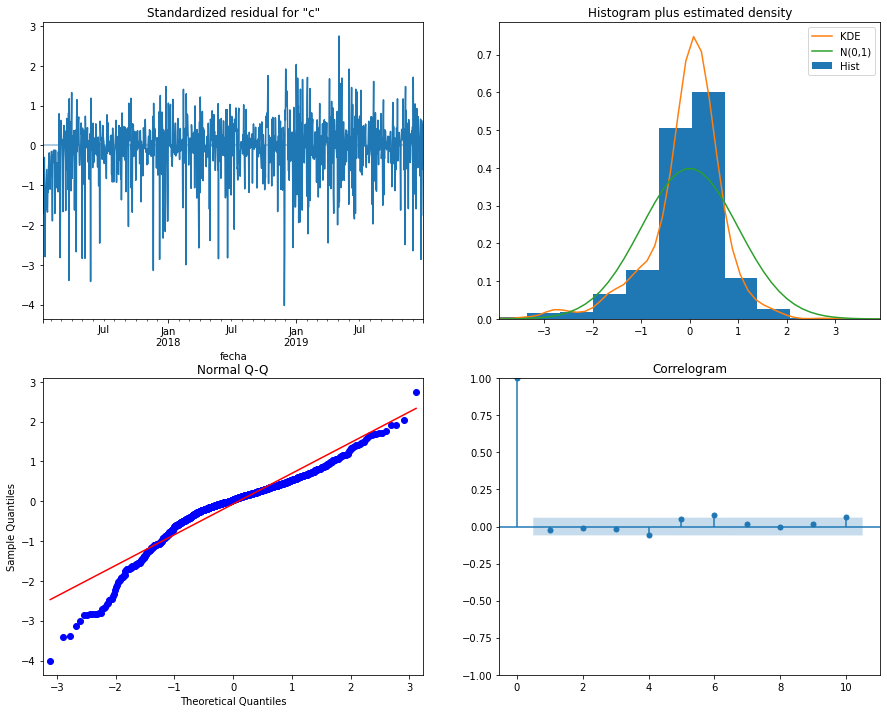

In [93]:
diagnostico = resultados.plot_diagnostics(figsize=(15, 12))
plt.show()

A partir de las gráficas, los residuos parecen estar distribuidos normalmente alrededor de 0, que es la condición que necesitamos,para ganerar predicciones-

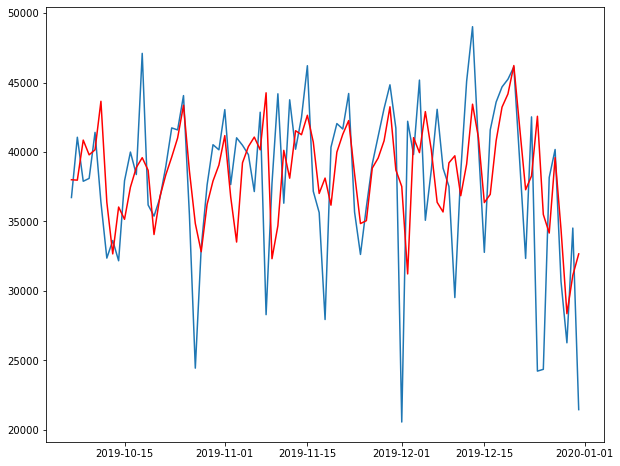

In [178]:
# One step
pred = resultados.predict(start=datetime.datetime(2019,10,6),dynamic=False)
diario_2 = diario.cantidad_pasos['2019-10-06':]
plt.figure(figsize=(10,8))
pyplot.plot(diario_2)
pyplot.plot(pred,color='red')
pyplot.show()

Predicción para los últimos 6 (junio 2019 - diciembre 2019) meses de la serie de tiempo

In [179]:
y_forecasted = pred
y_truth = diario.cantidad_pasos['2019-10-06':]
rmse_so = np.sqrt(mean_squared_error(y_truth,y_forecasted))
print(f'RMSE de SARIMAX One-Step es: {rmse_so }')

RMSE de SARIMAX One-Step es: 5341.289536200653


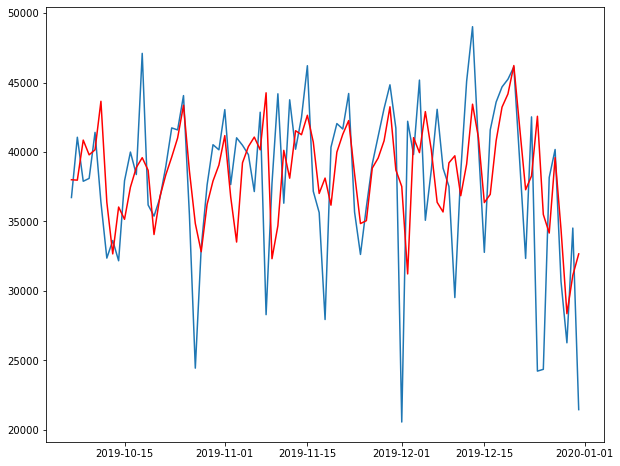

In [161]:
# Multi step
pred_2 = resultados.predict(start=datetime.datetime(2019,10,6),dynamic=True)
diario_3 = diario.cantidad_pasos['2019-10-06':]
plt.figure(figsize=(10,8))
pyplot.plot(diario_3)
pyplot.plot(pred,color='red')
pyplot.show()

In [162]:
y_forecasted_2 = pred_2
y_truth = diario.cantidad_pasos['2019-10-06':]
rmse_so_m = np.sqrt(mean_squared_error(y_truth,y_forecasted_2))
print(f'RMSE de SARIMAX Multi-Step es: {rmse_so_m }')

RMSE de SARIMAX Multi-Step es: 5706.977526149229


### Comparando ambos modelos:
RMSE de AR: 9139.531
RMSE de SARIMAX One-Step es: 5341.289536200653
RMSE de SARIMAX Multi-Step es: 5706.977526149229

El modelo con menor RMSE es Sarimax one-step, se utilizara para realizar la predicción a futuro.

## Pronóstico a futuro

A continuacion vamos a predecir la cantidad de vehiculos para el primer trimestre del 2020 utilizando el modelo Sarimax One step
Para pronosticar a futuro usamos get_forecast()atributo de nuestro objeto de serie temporal puede calcular valores pronosticados para un número específico de pasos adelante. Podemos usar la salida de este código para trazar la serie de tiempo y los pronósticos de sus valores futuros.

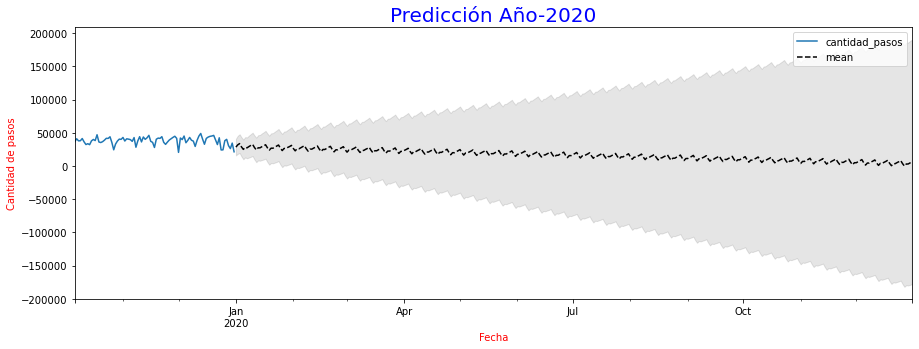

In [156]:
fig, ax = plt.subplots(figsize=(15, 5))

# Plot the data (here we are subsetting it to get a better look at the forecasts)
diario['cantidad_pasos'].loc['2019-10-06':].plot(ax=ax)

# Construct the forecasts
fcast = resultados.get_forecast(steps=datetime.datetime(2020,12,31)).summary_frame()
fcast['mean'].plot(ax=ax, style='k--')
ax.fill_between(fcast.index, fcast['mean_ci_lower'], fcast['mean_ci_upper'], color='k', alpha=0.1);
plt.title("Predicción Año-2020", color= 'blue', fontsize=20)
plt.xlim(datetime.datetime(2019,10,6), datetime.datetime(2020,12,31))
ax.set_xlabel('Fecha', color='red')
ax.set_ylabel('Cantidad de pasos', color='red')

plt.legend()
plt.show()

In [150]:
print(fcast)

cantidad_pasos        mean     mean_se  mean_ci_lower  mean_ci_upper
2020-01-01      28520.4203   6415.5706     15946.1329     41094.7077
2020-01-02      31939.3139   6973.8954     18270.7300     45607.8978
2020-01-03      33781.8795   7183.9425     19701.6110     47862.1480
2020-01-04      28800.7095   7368.8502     14358.0284     43243.3905
2020-01-05      25047.3629   7575.9965     10198.6827     39896.0431
...                    ...         ...            ...            ...
2020-12-27        -32.4623  92831.3812   -181978.6260    181913.7014
2020-12-28       3069.4065  93108.4017   -179419.7076    185558.5205
2020-12-29       3026.3225  93384.8170   -180004.5555    186057.2005
2020-12-30       4633.3456  93686.5967   -178989.0098    188255.7011
2020-12-31       6013.1664  93972.3640   -178169.2825    190195.6153

[366 rows x 4 columns]


Podemos observar los valores para las predicciones por día de la cantidad de pasos para el año 2020, en el cual tenemos un promedio, límmite inferior y límite superior.

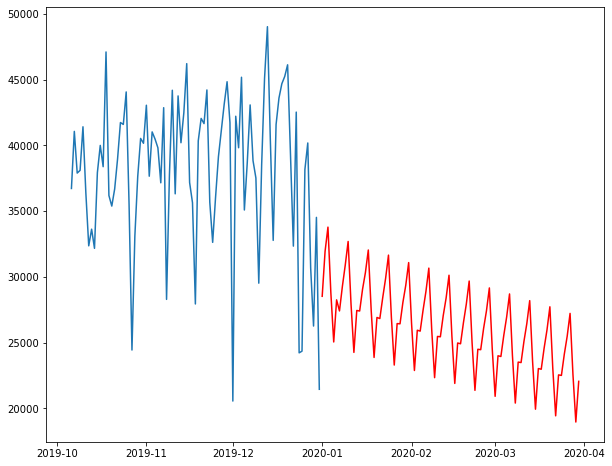

In [154]:
ax_2 = diario['cantidad_pasos'].loc['2019-10-06':]
fcast_2 = fcast['mean'].loc[:'2020-3-30']

plt.figure(figsize=(10,8))
pyplot.plot(ax_2)
pyplot.plot(fcast_2,color='red')
pyplot.show()

En este gráfico se observa más en detalle  la predicción para el primer trimestre del 2020, no resulta muy confiable los resultados a la vista. 

### Próximos pasos

Se propone utilizar la libreria prophet para hacer pronosticos para el flujo de vehiculos para el año 2020.
y tambien redes neuronales con la libreria  keras para predecir la cantidad de vehiculos para el año 2020.

In [34]:
from fbprophet import Prophet

Importing plotly failed. Interactive plots will not work.


In [35]:
#se indexa el dataframe diario
diario.reset_index(inplace=True,drop=False)
diario

,fecha,cantidad_pasos,tend
0,2017-01-01,31183.0,47372.1607
1,2017-01-02,51568.0,47802.7097
2,2017-01-03,51093.0,48223.1404
3,2017-01-04,53332.0,48625.6880
4,2017-01-05,56486.0,49004.3812
...,...,...,...
1090,2019-12-27,40182.0,32942.3429
1091,2019-12-28,30681.0,32126.4289
1092,2019-12-29,26259.0,31297.1238
1093,2019-12-30,34523.0,30460.1442


In [38]:
# Conversion y renombre  de los campos para preparar los datos para el modelo: y = cantidad de pasos y ds = fecha
diario_prophet = diario
diario_prophet['ds'] = pd.to_datetime(diario_prophet['fecha'])
diario_prophet = diario_prophet.drop(columns=['fecha', 'tend'])
diario_prophet = diario_prophet.rename(columns = {'cantidad_pasos':'y'})
diario_prophet

,y,ds
0,31183.0,2017-01-01
1,51568.0,2017-01-02
2,51093.0,2017-01-03
3,53332.0,2017-01-04
4,56486.0,2017-01-05
...,...,...
1090,40182.0,2019-12-27
1091,30681.0,2019-12-28
1092,26259.0,2019-12-29
1093,34523.0,2019-12-30


In [39]:
# cortamos el dataset en un fecha de corte, en este caso hasta septiembre del año 2019 
split_date_2 = '2019-09-30'
diario_prophet1 = diario_prophet.loc[diario_prophet.ds <= split_date_2].copy()
diario_prophet1

,y,ds
0,31183.0,2017-01-01
1,51568.0,2017-01-02
2,51093.0,2017-01-03
3,53332.0,2017-01-04
4,56486.0,2017-01-05
...,...,...
998,43110.0,2019-09-26
999,44985.0,2019-09-27
1000,41925.0,2019-09-28
1001,38348.0,2019-09-29


In [40]:
# definimos el modelo y entrenamos con los datos de hasta septiembre de 2019
m_prop = Prophet(weekly_seasonality=True,
            daily_seasonality=True )
m_prop.fit(diario_prophet1)

In [41]:
#hacemos la predicción 
forecast = m_prop.predict(diario_prophet1)

In [45]:
# Predicciones para 92 dias (para completar el año)
future = m_prop.make_future_dataframe(periods=92)
future.tail

<bound method NDFrame.tail of              ds
0    2017-01-01
1    2017-01-02
2    2017-01-03
3    2017-01-04
4    2017-01-05
...         ...
1090 2019-12-27
1091 2019-12-28
1092 2019-12-29
1093 2019-12-30
1094 2019-12-31

[1095 rows x 1 columns]>

In [46]:
#Prediccion en future, a 92 dias, que resulta 3 nuevos atributos
forecast = m_prop.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]

,ds,yhat,yhat_lower,yhat_upper
0,2017-01-01,39088.5829,33097.1942,45118.4014
1,2017-01-02,45122.7903,38794.9438,51464.5330
2,2017-01-03,46338.4359,40381.7479,52282.0405
3,2017-01-04,48160.2000,41989.3979,54548.0713
4,2017-01-05,49331.0711,43457.7453,54996.7979
...,...,...,...,...
1090,2019-12-27,43657.1226,37655.8183,49433.0026
1091,2019-12-28,35415.2378,29598.1677,41217.1248
1092,2019-12-29,30526.2678,24589.0590,36550.0260
1093,2019-12-30,36435.9637,30311.9906,42484.9643


El método de predicción asigna a cada fila en el futuro un valor predicho que denomina yhat. Si pasa las fechas históricas, proporcionará un ajuste en la muestra. El objeto de pronóstico aquí es un nuevo marco de datos que incluye una columna yhat con el pronóstico, así como columnas para componentes e intervalos de incertidumbre.

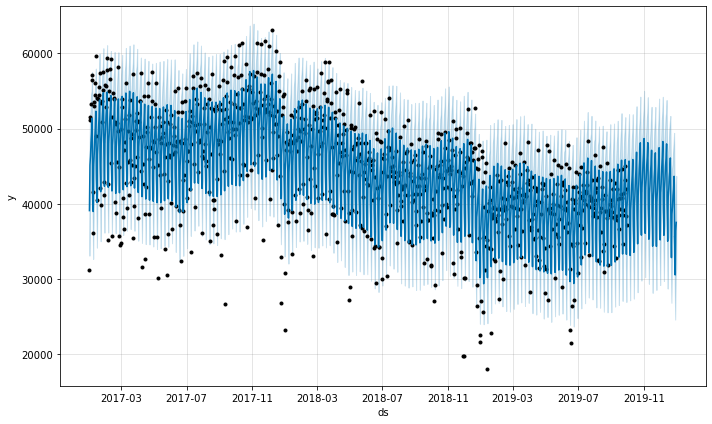

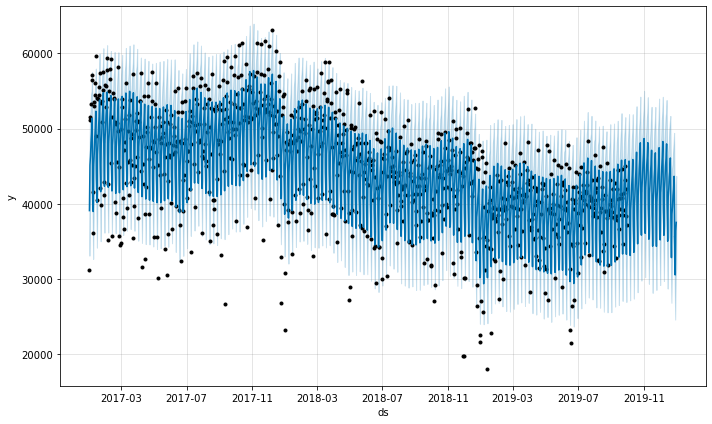

In [47]:
m_prop.plot(forecast)

Aqui se observa como el modelo predice los datos del ultimo trimestre del año 2019, con intervalos de incertidumbre. 

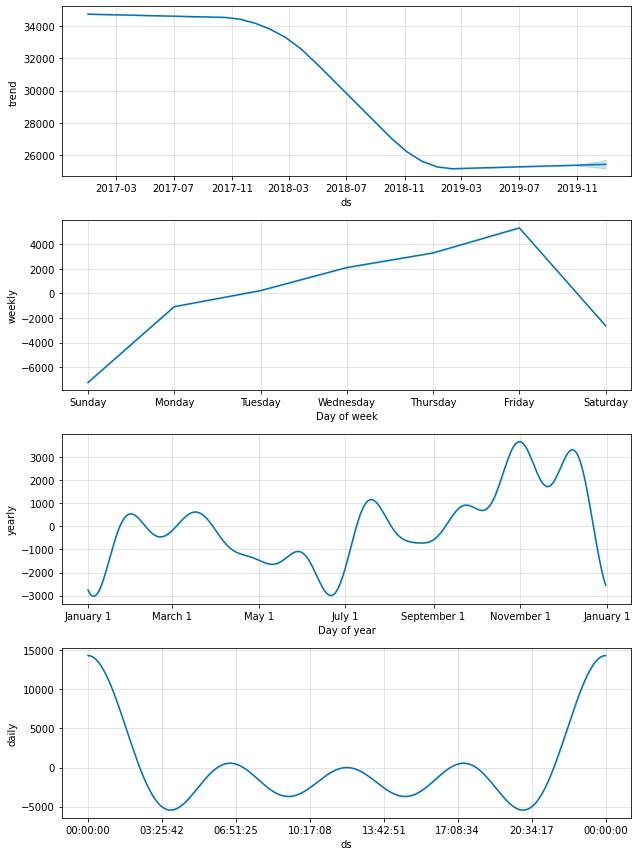

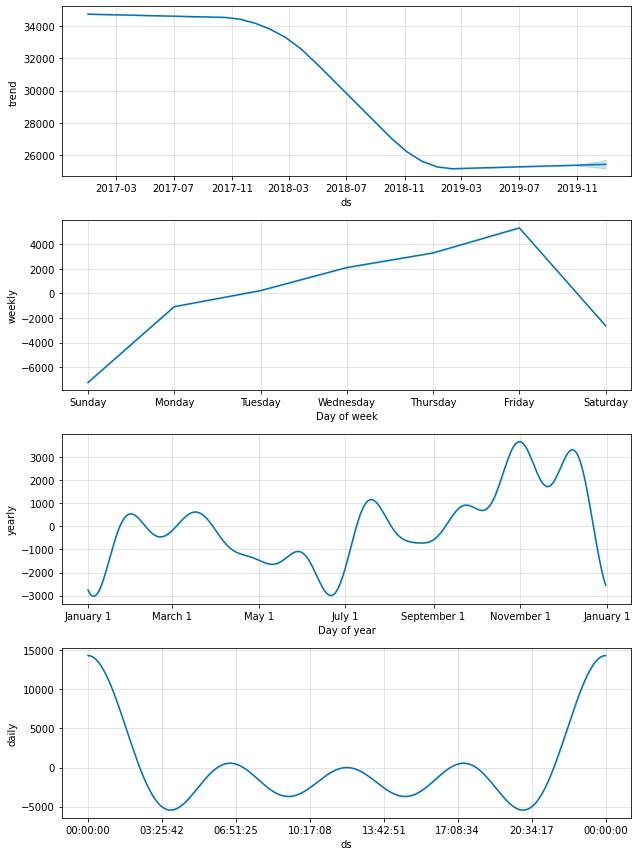

In [48]:
#componentes de la serie y de la prediccion 
m_prop.plot_components(forecast)

Estos gráficos muestran la tendencia, la tendencia semanal, diaria y anual. Se observa notablemente que la cantidad de pasos descendió considerablemente a partir de marzo del 2018. Semanalmente se observa que el día con mayor pasos de vehiculos es el día viernes y diariamente se observa una estacionalidad con pocos en las primeras y ultimas horas del día. 

Este modelo también podría usarse para predecir la cantida de vehiculos para el año 2020 y podemos evaluar su desempeñ al calcular el RMSE.

In [49]:
y_pred = forecast[['ds', 'yhat']].loc[forecast.ds < split_date_2]

In [50]:
y_true = diario_prophet[['ds', 'y']].loc[diario_prophet.ds < split_date_2]

In [56]:
from sklearn.metrics import mean_squared_error
rmse_prophet = np.sqrt(mean_squared_error(y_true,y_pred))
print(f'RMSE de Prophet: {rmse_prophet }')

RMSE de Prophet: 4694.008190393821


El valor del RMSE resulta por debajo del modelo Sarimax one-step (RMSE de SARIMAX One-Step es: 5341.289536200653), lo que resulta un buen modelo para predecir.

### ¿Que otras preguntas podemos responder a partir de estos datos?
-¿Qué peaje de la ciudad de buenos aires tiene mayor flujo vehicular? se  planeta la siguiente interrogante: se podrá pronosticar que peaje de la ciudad de buenos aires tendra mayor pasos en un determinado dia de la semana?

Para responder estas preguntas debemos:
1. Explorar los datos : observar tendencias
2. Procesar los datos: eliminar outliers, transformar variables categóricas en numéricas. Remuestrear los datos por día.  En este caso debemos transformar la variable 'dia' en una variable numérica y la variable 'estacion' en numérica también. 
3. Explorar la serie de tiempo: estacionalidad, prueba de estacionalidad ADFuller,  autocorrelacion y correlacion parcial. 
4. Para hacer el pronóstico vamos a crear modelos con la libreria prophet y sarimax

Para proyecto 4 de la carrera, se incluirá los datos del año 2020, y se estudiara cómo el transito de ese año en medio de una pandemia afecto las tendencias, estacionalidad y como varian los modelos pronósticos y predictivos incluyendo esos datos. 